In [1]:
# import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import pearsonr
import missingno as msno

# Pandas warning messages (optional)
pd.options.mode.chained_assignment = None  #default='warn'

# Plot options
import matplotlib.pyplot as plt
import seaborn as sns
sns.palplot(sns.color_palette('deep'))
sns.set_style("whitegrid")
%matplotlib inline

#### The dataset was downloaded from [insideairbnb](http://insideairbnb.com/get-the-data.html) for the city of Austin, Date Compiled on March 17th, 2020. 
#### Let's import the dataset and take a look at the first few observations.

In [2]:
# import dataset
df = pd.read_csv('data/listings.csv', low_memory=False)
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
1,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
3,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.12
4,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90


In [3]:
# shape
df.shape

(11668, 106)

The Airbnb dataset for Austin, TX consists of 106 features and 11668 observations.

In [4]:
# specifying max_cols=df.shape[1] so we can look at the columns in .info()
df.info(max_cols=df.shape[1])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11668 entries, 0 to 11667
Data columns (total 106 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11668 non-null  int64  
 1   listing_url                                   11668 non-null  object 
 2   scrape_id                                     11668 non-null  int64  
 3   last_scraped                                  11668 non-null  object 
 4   name                                          11668 non-null  object 
 5   summary                                       11244 non-null  object 
 6   space                                         9083 non-null   object 
 7   description                                   11461 non-null  object 
 8   experiences_offered                           11668 non-null  object 
 9   neighborhood_overview                         7937 non-null 

In [5]:
# ordering null columns based on the number of null values in each column
df.isnull().sum().sort_values(ascending=False)[:25]

neighbourhood_group_cleansed    11668
thumbnail_url                   11668
medium_url                      11668
xl_picture_url                  11668
license                         11621
square_feet                     11476
monthly_price                   10931
weekly_price                    10793
notes                            6115
access                           4917
transit                          4370
host_about                       4099
interaction                      3862
house_rules                      3759
neighborhood_overview            3731
host_response_rate               3462
host_response_time               3462
security_deposit                 3100
host_acceptance_rate             2765
review_scores_location           2675
review_scores_value              2674
review_scores_communication      2670
review_scores_checkin            2670
review_scores_cleanliness        2669
review_scores_accuracy           2669
dtype: int64

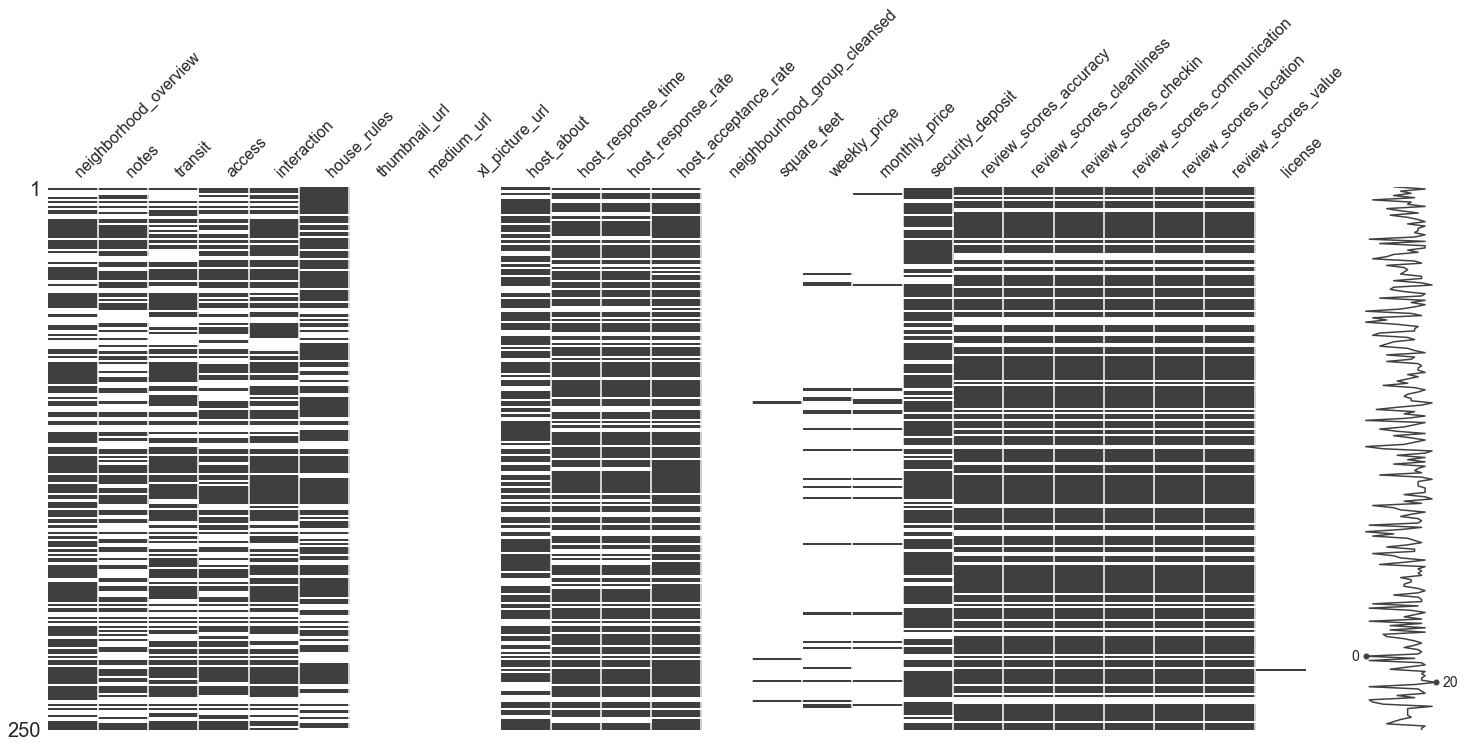

In [6]:
filtered_data = msno.nullity_filter(df, filter='bottom', n=25, p=0.999) # or filter='top'
msno.matrix(filtered_data.sample(250))

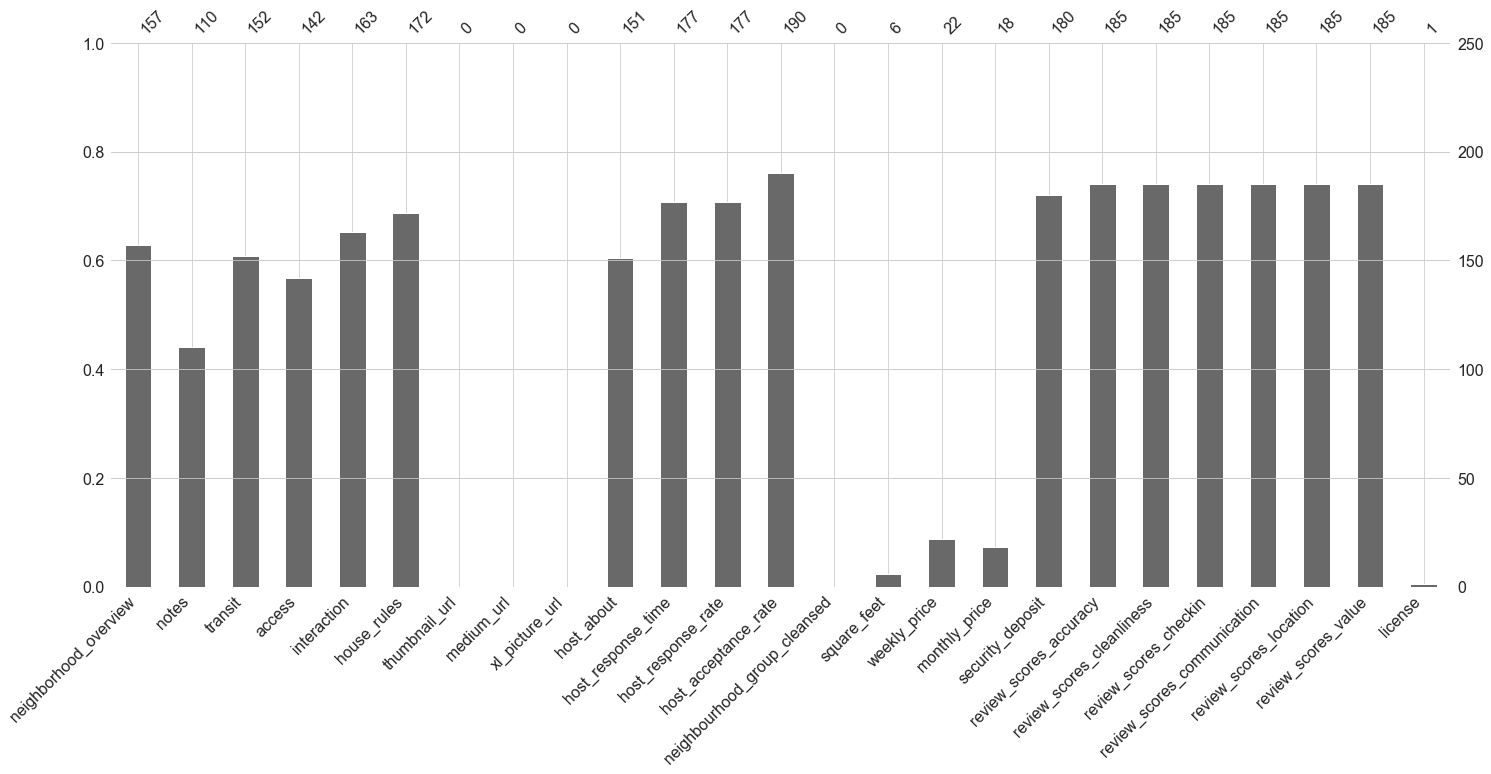

In [7]:
msno.bar(filtered_data.sample(250))

Features like 'square_feet', 'monthly_price' or 'weekly_price' have a lot of NULL values but we can use bedroom, bathroom, and accommodates data to calculate the property size and also use 'price' for our prediction.

In [8]:
df[['price','monthly_price', 'weekly_price']]

,price,monthly_price,weekly_price
0,$225.00,NaN,NaN
1,$100.00,NaN,NaN
2,$95.00,NaN,NaN
3,$40.00,NaN,$160.00
4,$99.00,"$1,900.00",$700.00
...,...,...,...
11663,$60.00,NaN,NaN
11664,$40.00,NaN,NaN
11665,$40.00,NaN,NaN
11666,$45.00,NaN,NaN


In [9]:
# Looking at describe() to get some insights on price and other numerical values
df.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_listings_count,host_total_listings_count,neighbourhood_cleansed,neighbourhood_group_cleansed,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,1.166800e+04,1.166800e+04,0.0,0.0,0.0,1.166800e+04,11666.000000,11666.000000,11668.000000,0.0,...,8999.000000,8998.000000,8998.000000,8993.000000,8994.000000,11668.000000,11668.000000,11668.000000,11668.000000,9146.000000
mean,2.372608e+07,2.020032e+13,NaN,NaN,NaN,7.673078e+07,66.963398,66.963398,78722.143469,NaN,...,9.607512,9.838964,9.848188,9.779162,9.587725,13.572506,12.477288,0.715975,0.350531,1.721717
std,1.314942e+07,2.511826e+00,NaN,NaN,NaN,8.628560e+07,281.215856,281.215856,20.689544,NaN,...,0.838195,0.611808,0.600158,0.615760,0.794404,41.256138,41.041238,2.807207,3.948567,2.122986
min,2.265000e+03,2.020032e+13,NaN,NaN,NaN,2.300000e+01,0.000000,0.000000,78701.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.275706e+07,2.020032e+13,NaN,NaN,NaN,8.761906e+06,1.000000,1.000000,78704.000000,NaN,...,9.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.260000
50%,2.361444e+07,2.020032e+13,NaN,NaN,NaN,3.939813e+07,1.000000,1.000000,78717.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,0.000000,0.000000,1.000000
75%,3.599878e+07,2.020032e+13,NaN,NaN,NaN,1.185659e+08,4.000000,4.000000,78744.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000,3.000000,1.000000,0.000000,2.510000
max,4.293155e+07,2.020032e+13,NaN,NaN,NaN,3.416244e+08,2016.000000,2016.000000,78759.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,248.000000,248.000000,31.000000,48.000000,41.270000


Notice that 'price' is not included on the describe() above! Let's investigate why 'price' did not show up!

In [10]:
# describe for price
df['price'].head()

0    $225.00
1    $100.00
2     $95.00
3     $40.00
4     $99.00
Name: price, dtype: object

'price' is type object and needs to be transformed to the correct data type.

In [11]:
# Convert price to from currency to float
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

In [12]:
# Verify price type is float
df['price'].head()

0    225.0
1    100.0
2     95.0
3     40.0
4     99.0
Name: price, dtype: float64

In [13]:
# no. of unique values
df.nunique()

id                                              11668
listing_url                                     11668
scrape_id                                           1
last_scraped                                        1
name                                            11423
                                                ...  
calculated_host_listings_count                     37
calculated_host_listings_count_entire_homes        36
calculated_host_listings_count_private_rooms       12
calculated_host_listings_count_shared_rooms         6
reviews_per_month                                 835
Length: 106, dtype: int64

In [14]:
# value counts by room_type
print(df['room_type'].value_counts())

Entire home/apt    8848
Private room       2610
Shared room         159
Hotel room           51
Name: room_type, dtype: int64


In [15]:
# value counts 
print(df['neighbourhood'].value_counts())
print('')
print(df['room_type'].value_counts())

East Downtown          1087
Downtown                742
Travis Heights          462
University of Texas     434
East Riverside          374
                       ... 
Anderson Mill            22
Mesa Park                12
Cat Mountian             11
Walnut Creek              7
Canyon Mesa               6
Name: neighbourhood, Length: 78, dtype: int64

Entire home/apt    8848
Private room       2610
Shared room         159
Hotel room           51
Name: room_type, dtype: int64


In [16]:
df.neighbourhood_cleansed

0        78702
1        78702
2        78702
3        78729
4        78704
         ...  
11663    78704
11664    78741
11665    78741
11666    78704
11667    78721
Name: neighbourhood_cleansed, Length: 11668, dtype: int64

In [17]:
df.price.describe()

count    11668.000000
mean       484.237830
std       1480.352627
min          0.000000
25%         80.000000
50%        149.000000
75%        300.000000
max      14298.000000
Name: price, dtype: float64

In [18]:
price_bins=[]
for price in df.price:
    if price < 81:
        price_bins.append('low')
    if price < 150:
        price_bins.append('med')
    else:
        price_bins.append('high')

In [19]:
[[x,price_bins.count(x)] for x in set(price_bins)]

[['med', 5898], ['high', 5770], ['low', 2944]]

In [20]:
df['price_bins'] = pd.Series(price_bins)

In [21]:
df[['price', 'price_bins']]

,price,price_bins
0,225.0,high
1,100.0,med
2,95.0,med
3,40.0,low
4,99.0,med
...,...,...
11663,60.0,med
11664,40.0,high
11665,40.0,high
11666,45.0,med


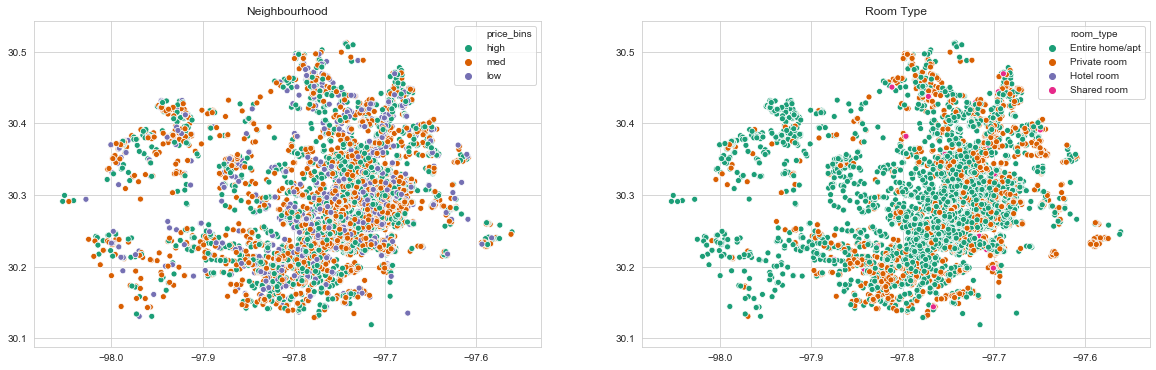

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

sns.scatterplot(data=df, x='longitude', y='latitude', hue='price_bins', palette='Dark2', ax=axes[0])
sns.scatterplot(data=df, x='longitude', y='latitude', hue='room_type', palette='Dark2', ax=axes[1])

axes[0].set_title('Neighbourhood')
axes[1].set_title('Room Type')
axes[0].set_ylabel('')
axes[0].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xlabel('')

plt.show()

In [23]:
columns_list = ['room_type', 'price', 'accommodates', 'bathrooms', 'bedrooms',  
                'host_is_superhost', 'neighbourhood_cleansed', 'longitude', 'latitude', 
                'number_of_reviews', 'availability_365', 'reviews_per_month', 
                'review_scores_rating', 'minimum_nights']

df = df[columns_list]

In [24]:
df.head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,reviews_per_month,review_scores_rating,minimum_nights
0,Entire home/apt,225.0,4,2.0,2.0,t,78702,-97.71398,30.27750,24,0,0.18,93.0,30
1,Private room,100.0,2,1.0,1.0,t,78702,-97.71379,30.27577,9,0,0.07,91.0,30
2,Entire home/apt,95.0,3,1.0,1.0,t,78702,-97.73448,30.26112,529,334,3.94,97.0,2
3,Private room,40.0,2,1.0,1.0,t,78729,-97.78422,30.45697,257,14,2.12,98.0,1
4,Entire home/apt,99.0,2,1.0,0.0,t,78704,-97.73726,30.24829,112,0,0.90,99.0,3


Noting for cleanup:

Price needs to be converted to float
Missing NaN values need data imputed or rows removed
Categorical columns need to be converted to dummy variables (get_dummies)
To continue the data exploration, I need to perform some cleanup procedures. In the data preparation section that follows, I'll create a cleanup function to put these cleaning steps together.

In [25]:
print("Dataset has {} row entries.".format(df.shape[0]))

Dataset has 11668 row entries.


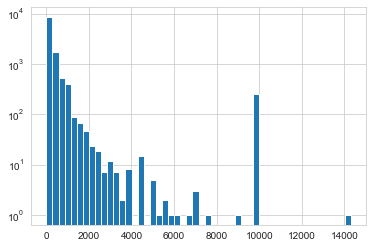

In [26]:
# What are the distribution of rental prices
fig, ax = plt.subplots()
ax.hist(df['price'], bins=50)
ax.set_yscale("log", nonposy='clip')
plt.show();

In [27]:
# Create 'price_per_person' feature
df['price_per_person'] = df['price']/df['accommodates']

df['price_per_person'].value_counts().sort_index(ascending=False).head(10)

5000.000000     13
3500.000000      1
3333.333333      3
2500.000000    161
2000.000000      4
1750.000000      1
1666.666667     65
1500.000000      1
1200.000000      1
1191.500000      1
Name: price_per_person, dtype: int64

In [28]:
df.loc[df['price_per_person'] > 1000.00]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,reviews_per_month,review_scores_rating,minimum_nights,price_per_person
404,Private room,7000.0,4,1.0,1.0,f,78749,-97.86655,30.22530,2,0,0.02,80.0,3,1750.000000
1179,Private room,1200.0,1,1.0,1.0,f,78741,-97.70267,30.23572,1,0,0.02,100.0,30,1200.000000
3506,Entire home/apt,10000.0,4,1.0,2.0,f,78703,-97.77171,30.30439,0,365,NaN,NaN,30,2500.000000
3950,Private room,10000.0,2,1.0,1.0,f,78723,-97.69715,30.29481,0,364,NaN,NaN,1,5000.000000
5461,Entire home/apt,10000.0,5,1.0,1.0,f,78701,-97.75059,30.26969,1,180,0.04,100.0,500,2000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11613,Entire home/apt,10000.0,6,2.0,2.0,f,78746,-97.78618,30.26654,0,180,NaN,NaN,1,1666.666667
11616,Entire home/apt,10000.0,4,1.0,1.0,f,78752,-97.72279,30.33052,0,177,NaN,NaN,1,2500.000000
11617,Entire home/apt,10000.0,4,1.0,1.0,f,78752,-97.72102,30.33087,0,180,NaN,NaN,1,2500.000000
11629,Entire home/apt,3000.0,2,1.0,1.0,f,78704,-97.76023,30.24547,0,103,NaN,NaN,3,1500.000000


C:\Users\rtalebiz\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


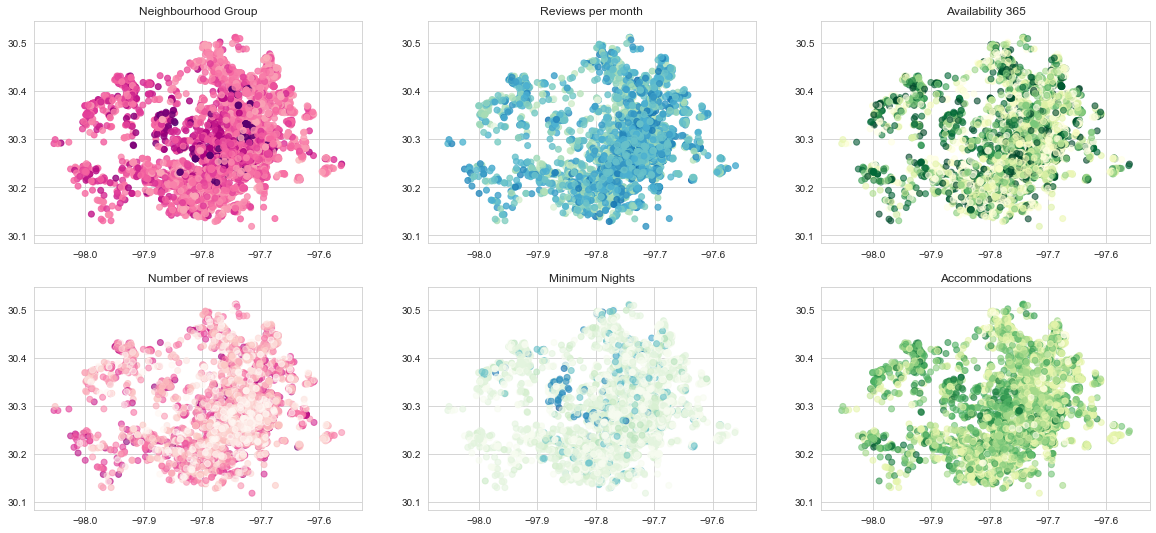

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

axes[0,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['price']), cmap='RdPu', alpha=0.8)
axes[0,0].set_title('Neighbourhood Group')

axes[0,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['reviews_per_month']), cmap='GnBu', alpha=0.8)
axes[0,1].set_title('Reviews per month')

axes[0,2].scatter(x=df['longitude'], y=df['latitude'], c=df['availability_365'], cmap='YlGn', alpha=0.6)
axes[0,2].set_title('Availability 365')

axes[1,0].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['number_of_reviews']), cmap='RdPu', alpha=0.6)
axes[1,0].set_title('Number of reviews')

axes[1,1].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['minimum_nights']), cmap='GnBu', alpha=0.6)
axes[1,1].set_title('Minimum Nights')

axes[1,2].scatter(x=df['longitude'], y=df['latitude'], c=np.log(df['accommodates']), cmap='YlGn', alpha=0.6)
axes[1,2].set_title('Accommodations')

plt.show()

Upon reviewing the url listings, the houses listed as with extreme prices looked like automated (or unmaintained) listings with little to no reviews with some being incorrectly priced at the time of the source data scrape. I'm opting to remove them from this analysis since they don't pass my common sense as a consumer. However, it would be intersting to examine other popular cities to see if they had similar outliers.

In [30]:
# remove rows with > $1000 per person
df = df.loc[df['price_per_person'] <= 1000.00]

# verify removal
df['price_per_person'].value_counts().sort_index(ascending=False).head()

1000.000000    4
980.000000     1
937.500000     1
875.000000     1
833.333333     1
Name: price_per_person, dtype: int64

In [31]:
df.describe()

,price,accommodates,bathrooms,bedrooms,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,reviews_per_month,review_scores_rating,minimum_nights,price_per_person
count,11416.000000,11416.000000,11403.000000,11401.000000,11416.000000,11416.000000,11416.000000,11416.000000,11416.000000,8924.000000,8795.000000,11416.000000,11416.000000
mean,276.498598,4.714961,1.552311,1.798351,78721.966538,-97.751277,30.277975,32.007533,134.223196,1.686609,96.095168,5.317186,57.816575
std,469.550298,3.282795,0.878670,1.280468,20.598962,0.056845,0.057474,64.179349,135.769308,2.125318,7.072462,16.113789,68.269731
min,0.000000,1.000000,0.000000,0.000000,78701.000000,-98.053550,30.118850,0.000000,0.000000,0.010000,20.000000,1.000000,0.000000
25%,80.000000,2.000000,1.000000,1.000000,78703.000000,-97.767572,30.244400,1.000000,0.000000,0.250000,95.000000,1.000000,25.000000
50%,142.000000,4.000000,1.000000,1.000000,78717.000000,-97.744905,30.266690,7.000000,86.000000,0.960000,98.000000,2.000000,37.500000
75%,299.000000,6.000000,2.000000,2.000000,78744.000000,-97.721127,30.298212,32.000000,274.000000,2.420000,100.000000,3.000000,62.500000
max,10000.000000,33.000000,17.000000,23.000000,78759.000000,-97.560620,30.512280,947.000000,365.000000,41.270000,100.000000,365.000000,1000.000000


The review ratings (review_scores_rating) are missing a lot of data. However, due to the small size of the data set, I'll opt to fill the missing values of the ratings scores at the cost of diluting the ratings feature importance. Before I do this, I'll save a copy of the DataFrame in it's current state since I want to look at a plot of price vs. rating later.

In [32]:
# Imputed mean value of review scores to missing data in review_scores_rating feature
print("Filling NaN 'review_scores_rating' with {:.3f}.".format(df['review_scores_rating'].mean()))
df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)

Filling NaN 'review_scores_rating' with 96.095.


The bathrooms feature is missing some data. I'll update the NaNs based on a rough guess that for every 4 people the rental can accommodate, there is 1 bathroom.

In [33]:
df[df['bathrooms'].isnull()].head()

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,reviews_per_month,review_scores_rating,minimum_nights,price_per_person
106,Entire home/apt,175.0,5,NaN,3.0,f,78723,-97.68496,30.30340,1,0,0.01,80.000000,2,35.000000
120,Entire home/apt,350.0,4,NaN,2.0,f,78730,-97.79621,30.35672,0,0,NaN,96.095168,4,87.500000
145,Private room,80.0,2,NaN,1.0,f,78759,-97.76717,30.42198,33,83,0.34,96.000000,32,40.000000
156,Entire home/apt,400.0,3,NaN,2.0,f,78702,-97.72019,30.25820,0,0,NaN,96.095168,3,133.333333
173,Entire home/apt,225.0,2,NaN,2.0,f,78746,-97.80005,30.34442,1,0,0.01,80.000000,3,112.500000


In [34]:
# Bathrooms is getting scaled later, so I do not care about making it a discrete value
# Also 0.5 is commonly known as a 'half-bath'
df['bathrooms'].fillna((df['accommodates']/4), inplace=True)

In [35]:
df.loc[[135]]

,room_type,price,accommodates,bathrooms,bedrooms,host_is_superhost,neighbourhood_cleansed,longitude,latitude,number_of_reviews,availability_365,reviews_per_month,review_scores_rating,minimum_nights,price_per_person
135,Private room,75.0,2,1.0,1.0,t,78702,-97.72514,30.27235,460,351,4.72,97.0,2,37.5


In [36]:
df.isnull().sum()

room_type                    0
price                        0
accommodates                 0
bathrooms                    0
bedrooms                    15
host_is_superhost            2
neighbourhood_cleansed       0
longitude                    0
latitude                     0
number_of_reviews            0
availability_365             0
reviews_per_month         2492
review_scores_rating         0
minimum_nights               0
price_per_person             0
dtype: int64

In [37]:
# Drop the few remaining rows with missing values
df.dropna(inplace=True)

The data set severly lacks in samples for larger houses. I'm going to remove some of the extreme rows for these cases since I'm more interested in examining typically sized houses. Another study could be done for very large rental using data from all over the US.

In [38]:
df['bathrooms'].value_counts().sort_index(ascending=False)

9.00       1
8.00       3
7.50       1
7.00       2
6.50       9
6.00      14
5.50      11
5.00      30
4.50      53
4.00     106
3.50     130
3.00     323
2.50     617
2.00    1766
1.75       1
1.50     618
1.25       1
1.00    5198
0.50      13
0.25       1
0.00      21
Name: bathrooms, dtype: int64

In [39]:
df.groupby('bathrooms').price.median()

bathrooms
0.00      57.0
0.25      88.0
0.50      79.0
1.00      97.0
1.25     175.0
1.50      99.0
1.75    1000.0
2.00     225.0
2.50     275.0
3.00     455.0
3.50     552.5
4.00     688.5
4.50     555.0
5.00     997.5
5.50    1665.0
6.00    1050.0
6.50    2250.0
7.00    1255.5
7.50    1000.0
8.00    2250.0
9.00    2100.0
Name: price, dtype: float64

In [40]:
df['accommodates'].value_counts().sort_index(ascending=False)

33       1
32       2
28       1
25       1
24       2
21       3
20       1
19       2
18       3
17       1
16     217
15      20
14      70
13      24
12     142
11      33
10     342
9       88
8      551
7      190
6     1276
5      466
4     1866
3      747
2     2556
1      314
Name: accommodates, dtype: int64

In [41]:
df.groupby('accommodates').price.mean()

accommodates
1       54.996815
2       94.003130
3      118.761714
4      204.814041
5      195.635193
6      285.370690
7      285.931579
8      444.802178
9      468.579545
10     708.710526
11     777.393939
12     542.528169
13     464.125000
14     585.800000
15     851.500000
16     695.861751
17    1170.000000
18    2075.666667
19    1740.000000
20    1750.000000
21    1722.000000
24    1622.500000
25     633.000000
28    1900.000000
32    1882.500000
33    1780.000000
Name: price, dtype: float64

In [42]:
# Remove extremely large rental listing due to low samples
df = df.loc[df['bathrooms'] <= 8]
df = df.loc[df['accommodates'] <= 16]

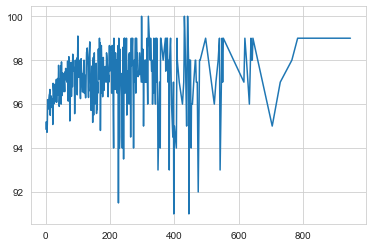

In [43]:
plt.plot(df.groupby('number_of_reviews').review_scores_rating.mean());

### Verify Data Quality
Need to verify that price is a float, review_scores_rating are not missing any values.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8901 entries, 0 to 11622
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   room_type               8901 non-null   object 
 1   price                   8901 non-null   float64
 2   accommodates            8901 non-null   int64  
 3   bathrooms               8901 non-null   float64
 4   bedrooms                8901 non-null   float64
 5   host_is_superhost       8901 non-null   object 
 6   neighbourhood_cleansed  8901 non-null   int64  
 7   longitude               8901 non-null   float64
 8   latitude                8901 non-null   float64
 9   number_of_reviews       8901 non-null   int64  
 10  availability_365        8901 non-null   int64  
 11  reviews_per_month       8901 non-null   float64
 12  review_scores_rating    8901 non-null   float64
 13  minimum_nights          8901 non-null   int64  
 14  price_per_person        8901 non-null  

### Data Preparation 
The data preparation process in the CRISP-DM cycle consists of:

##### Select your data
Clean your data
Construct required data
Integrate data (not required for this project)
Select your data
This is the stage of the project where you decide on the data that you're going to use for analysis. [source]. To answer the business questions posed at the beginning, I'm choosing to keep the following features:

'price' - target feature for the business questions
'room_type' - property type: house, private room, shared room
'accommodates' - property size metric
'bathrooms' - property size metric
'bedrooms' - property size metric
'host_is_superhost' - Airbnb host status
'neighbourhood_cleansed' - Location, ZIP code
'number_of_reviews' - Review metric
'review_scores_rating' - Review metric
'minimum_nights' - length of stay metric
#### Clean your data
This task involves raise the data quality to the level required by the analysis techniques that you've selected [source]. I'm creating a 'cleaning' function so that I don't have to repeat the above steps everytime I load the notebook.

In [45]:
def clean_listings_data(csv, review_impute = True):
    '''
    Takes a listings.csv file (insideairbnb.com) for a particular
    city and outputs a cleaned the data frame 
    for the feature_list defined below. Note that the feature_list
    is hardcoded since the cleaning operations may not work for a
    different set of features. 
    
    Input:
    csv - insideairbnb.com listings.csv 
    review_impute - create additional DataFrames with no or '0' imputation 
                    for NaNs in the 'review_scores_rating' column
    
    Output:
    df - Cleaned DataFrame, used for prediction model
    df_no_impute - DataFrame with no imputed values on 'review_scores_rating'
    df_zeros_impute - DataFrame with integer '0' imputed values on 'review_scores_rating'
    '''
    
    # Import and load data
    df = pd.read_csv('data/listings.csv', low_memory=False)
    
    # Select features to keep in DataFrame
    feature_list = ['room_type', 'price', 'accommodates', 'bathrooms', 
                    'bedrooms', 'host_is_superhost', 'neighbourhood_cleansed', 
                    'number_of_reviews', 'review_scores_rating', 'minimum_nights']
    df = df[feature_list]
    
    # Convert price to from currency to float
    df['price'] = df['price'].str.replace('$', '')
    df['price'] = df['price'].str.replace(',', '')
    df['price'] = df['price'].astype(float)
    
    # Create feature for price per person
    df['price_per_person'] = df['price']/df['accommodates']
    
    # Remove rows with > $1000 per person
    df = df.loc[df['price_per_person'] <= 1000.00]
    
    # df for specific plots - need data before 'review_scores_rating' imputation
    df_no_impute = df[['review_scores_rating', 'price', 'price_per_person', 
                    'number_of_reviews', 'bathrooms', 'bedrooms', 'accommodates']].copy()
    df_zeros_impute = df_no_impute.copy()
    df_no_impute.dropna(inplace=True)
    df_zeros_impute['review_scores_rating'].fillna(0, inplace=True)
    df_zeros_impute.dropna(inplace=True)

    # Imputed mean value of review scores to missing data in review_scores_rating feature
    df['review_scores_rating'].fillna((df['review_scores_rating'].mean()), inplace=True)
    
    # Bathrooms is getting scaled later, so I do not care about making it a discrete value
    df['bathrooms'].fillna((df['accommodates']/4), inplace=True)
    
    # Drop the few remaining rows with missing values
    df.dropna(inplace=True)
    
    # Remove extremely large rental listing due to low samples
    df = df.loc[df['bathrooms'] <= 8]
    df = df.loc[df['accommodates'] <= 16]
    
    print('clean_listings_data: Cleaning Complete')
    
    if review_impute:
        return df, df_no_impute, df_zeros_impute
    else:
        return df

# Run cleanup function
df, df_no_impute, df_zeros_impute = clean_listings_data('data/listings.csv')

clean_listings_data: Cleaning Complete


### Construct required data
This task includes constructive data preparation operations such as the production of derived attributes or entire new records, or transformed values for existing attributes. source

Now that the DataFrame is cleaned, I want to sort all of the ZIP codes for Austin the into several regions to simplify the analysis. This could be easily updated for anyone who wants to redraw my subjective boundaries. Also, for a different city, the following would need to be redone with the appropriate ZIP codes.

Additionally, I need to create dummy variables and scale the features for the regression models.

In [46]:
# Compress zipcode into 5 regions for 1 hot encoding
zip_central = [78701, 78702, 78703, 78704, 78705, 78712, 78722]
zip_north = [78726, 78727, 78728, 78729, 78731, 78750, 78751,  
             78756, 78758, 78759, 78757]
zip_west = [78730, 78732, 78733, 78734, 78735, 78736, 78738, 78746]
zip_south = [78737, 78739, 78745, 78749, 78748, 78742]
zip_east = [78717, 78719, 78721, 78723, 78724, 78725, 78741, 
            78744, 78747, 78752, 78753, 78754]

map_dict = {}
str_dict = {0: 'Central', 1: 'North', 2: 'West', 3: 'South', 4: 'East'}
area_list = [zip_central, zip_north, zip_west, zip_south, zip_east]

# Create a dict for the pandas map function to convert zip into region
for i in range(len(area_list)):
    for zipcode in area_list[i]:
        map_dict[zipcode] = str_dict[i]   

# Replace 'neighbourhood_cleansed' with 'region' feature
df['region'] = df['neighbourhood_cleansed'].map(map_dict)
df.drop(['neighbourhood_cleansed'], axis=1, inplace=True)

In [47]:
features_list = ['room_type', 'bathrooms', 'bedrooms', 'accommodates', 
                 'host_is_superhost',  'region', 'review_scores_rating', 'number_of_reviews']

# Create features and price DFs for sklearn inputs
features = df[features_list].copy()   # 'X'
price = df['price'].copy()            # 'y'

In [48]:
# Create dummy variables for 'room type', 'superhost' and 'region'
features = pd.get_dummies(features)
features.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,2.0,2.0,4,93.0,24,1,0,0,0,0,1,1,0,0,0,0
1,1.0,1.0,2,91.0,9,0,0,1,0,0,1,1,0,0,0,0
2,1.0,1.0,3,97.0,529,1,0,0,0,0,1,1,0,0,0,0
3,1.0,1.0,2,98.0,257,0,0,1,0,0,1,0,0,1,0,0
4,1.0,0.0,2,99.0,112,1,0,0,0,0,1,1,0,0,0,0


In [49]:
# Scale the quantitative features
# Note: using RobustScaler resulted in similar r2 results
scaler = MinMaxScaler()
numerical = ['bathrooms', 'bedrooms', 'review_scores_rating', 'accommodates', 'number_of_reviews']
features_scaled = features.copy()
features_scaled[numerical] = scaler.fit_transform(features_scaled[numerical])

In [50]:
features_scaled.head()

,bathrooms,bedrooms,accommodates,review_scores_rating,number_of_reviews,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t,region_Central,region_East,region_North,region_South,region_West
0,0.250,0.142857,0.200000,0.9125,0.025343,1,0,0,0,0,1,1,0,0,0,0
1,0.125,0.071429,0.066667,0.8875,0.009504,0,0,1,0,0,1,1,0,0,0,0
2,0.125,0.071429,0.133333,0.9625,0.558606,1,0,0,0,0,1,1,0,0,0,0
3,0.125,0.071429,0.066667,0.9750,0.271383,0,0,1,0,0,1,0,0,1,0,0
4,0.125,0.000000,0.066667,0.9875,0.118268,1,0,0,0,0,1,1,0,0,0,0


In [51]:
features_scaled.to_csv('data/listings_scaled.csv')